In [84]:
import numpy as np
from matplotlib.lines import Line2D
from expm_mul import expm_multiply
from scipy.sparse.linalg import eigs,norm
from scipy.special import factorial
import matplotlib.pyplot as plt
from fractions import Fraction
from scipy.sparse import csr_matrix,isspmatrix,bmat
import scipy as sci
from qutip import qload
def get_creation_operator(size,tp):
    return np.diag(np.sqrt(np.arange(1, size),dtype=tp), k=-1)
def get_annihilation_operator(size,tp):
    return np.diag(np.sqrt(np.arange(1, size),dtype=tp), k=1)
def get_s(A,b,tol):
    s=1
    if A.dtype==np.complex256:
        s=np.ceil(_exact_1_norm(A))
    else:
        while(1):
            norm_A = _exact_inf_norm(A)/s
#             max_term_notation=np.floor(norm_A)
#             max_term=1
#             for i in range(1,np.int(max_term_notation)):
#                 max_term=max_term*norm_A/i
#                 if max_term >= 10**16:
#                     break
#             if 10**-16 * max_term <= tol:
#                 break
            if 1e-16*np.exp(norm_A)<=tol:
                break
            s=s+1
    return s
def _exact_1_norm(A):
    # A compatibility function which should eventually disappear.
    if sci.sparse.isspmatrix(A):
        return max(abs(A).sum(axis=0).flat)
    else:
        return np.linalg.norm(A, 1)
def _expm_multiply_simple_core_global(A, B, tol=None):
    """
    A helper function.
    """
    if tol is None:
        tol =1e-16
    s=get_s(A,B,tol)
    F = B
    s=5
    c1 = _exact_1_norm(B)
    j=0
    while(1):
        coeff = s*(j+1)
        B =  A.dot(B)/coeff
        c2 = _exact_1_norm(B)
        F = F + B
        total_norm=norm_state(F)
        if (c1+c2)<tol*total_norm:
            m=j+1
            break
        c1 = c2
        j=j+1
    F =  F
    B = F
    for i in range(1,int(s)):
        c1=c2
        for j in range(m):
            coeff = s*(j+1)
            B =  A.dot(B)/coeff
            F = F + B
        F =  F
        B = F
    return F, m,s
def overnorm(A):
    if A.dtype==np.complex256:
        return _exact_inf_norm(A)
    else:
        return norm_two(A)
def _exact_inf_norm(A):
    # A compatibility function which should eventually disappear.
    if sci.sparse.isspmatrix(A):
        return max(abs(A).sum(axis=1).flat)
    else:
        return np.linalg.norm(A, np.inf)
def norm_two(A):
    if sci.sparse.isspmatrix(A):
        A=csr_matrix(A).conjugate().transpose()
        return np.sqrt(abs(eigs(A=A.dot(A),k=1,which='LM',return_eigenvectors=False)[0]))
    else:
        return np.linalg.norm(A)
def norm_state(A):
    return np.linalg.norm(A)
def block_fre(A,E):
    if isspmatrix(A) is False:
        A = np.block([[A, E], [np.zeros_like(A), A]])
    else:
        A = bmat([[A, E], [None, A]]).tocsc()
    return A
def difference(A,B):
    return overnorm(A-B)/overnorm(A)
def get_H(dim,tp):
    HILBERT_SIZE=dim
    Q_dim=6
    g=0.1*2*np.pi
    anharmonicity =-0.225
    a_dag = get_creation_operator(HILBERT_SIZE,tp)
    a = get_annihilation_operator(HILBERT_SIZE,tp)
    b_dag=get_creation_operator(Q_dim,tp)
    b=get_annihilation_operator(Q_dim,tp)
    A=np.kron(a,np.identity(Q_dim))
    A_dag=np.kron(a_dag,np.identity(Q_dim))
    B=np.kron(np.identity(HILBERT_SIZE),b)
    B_dag=np.kron(np.identity(HILBERT_SIZE),b_dag)
    H_trans = 1 / 2 * anharmonicity * np.dot(np.dot(b_dag, b),np.dot(b_dag,b)-np.identity(Q_dim))
    H0=g*(np.kron(a_dag,b)+np.kron(a,b_dag))+np.kron(np.identity(HILBERT_SIZE),H_trans)
    H=csr_matrix(-1j*(H0+0.5*2*np.pi*(np.dot(B_dag,B)+B+B_dag+1j*(B-B_dag))))
    vec=1/np.sqrt(HILBERT_SIZE*Q_dim)*np.ones(HILBERT_SIZE*Q_dim)
    return H,vec
def get_auxiliary(dim,tp,t):
    HILBERT_SIZE=dim
    Q_dim=6
    g=0.1*2*np.pi
    anharmonicity =-0.225
    a_dag = get_creation_operator(HILBERT_SIZE,tp)
    a = get_annihilation_operator(HILBERT_SIZE,tp)
    b_dag=get_creation_operator(Q_dim,tp)
    b=get_annihilation_operator(Q_dim,tp)
    A=np.kron(a,np.identity(Q_dim))
    A_dag=np.kron(a_dag,np.identity(Q_dim))
    B=np.kron(np.identity(HILBERT_SIZE),b)
    B_dag=np.kron(np.identity(HILBERT_SIZE),b_dag)
    H_trans = 1 / 2 * anharmonicity * np.dot(np.dot(b_dag, b),np.dot(b_dag,b)-np.identity(Q_dim))
    H0=g*(np.kron(a_dag,b)+np.kron(a,b_dag))+np.kron(np.identity(HILBERT_SIZE),H_trans)
    H=csr_matrix(-1j*(H0+0.5*2*np.pi*(np.dot(B_dag,B)+B+B_dag+1j*(B-B_dag))))
    vec=1/np.sqrt(HILBERT_SIZE*Q_dim)*np.ones(2*HILBERT_SIZE*Q_dim)
    vec[0:HILBERT_SIZE*Q_dim]=0
    A=block_fre(t*H,-1j*(B+B_dag))
    return A,vec
def get_norm(ts):
    tp=np.float64()
    anorm=[]
    for i in range(len(ts)):
        HILBERT_SIZE=200
        Q_dim=6
        g=0.1*2*np.pi
        anharmonicity =-0.225
        a_dag = get_creation_operator(HILBERT_SIZE,tp)
        a = get_annihilation_operator(HILBERT_SIZE,tp)
        b_dag=get_creation_operator(Q_dim,tp)
        b=get_annihilation_operator(Q_dim,tp)
        A=np.kron(a,np.identity(Q_dim))
        A_dag=np.kron(a_dag,np.identity(Q_dim))
        B=np.kron(np.identity(HILBERT_SIZE),b)
        B_dag=np.kron(np.identity(HILBERT_SIZE),b_dag)
        H_trans = 1 / 2 * anharmonicity * np.dot(np.dot(b_dag, b),np.dot(b_dag,b)-np.identity(Q_dim))
        H0=g*(np.kron(a_dag,b)+np.kron(a,b_dag))+np.kron(np.identity(HILBERT_SIZE),H_trans)
        H=ts[i]*csr_matrix(-1j*(H0+0.5*2*np.pi*(np.dot(B_dag,B)+B+B_dag+1j*(B-B_dag))))
        anorm.append(norm_two(H))
    return anorm
def get_norm_der(ts):
    tp=np.float64()
    anorm=[]
    for i in range(len(ts)):
        HILBERT_SIZE=20
        Q_dim=6
        g=0.1*2*np.pi
        anharmonicity =-0.225
        a_dag = get_creation_operator(HILBERT_SIZE,tp)
        a = get_annihilation_operator(HILBERT_SIZE,tp)
        b_dag=get_creation_operator(Q_dim,tp)
        b=get_annihilation_operator(Q_dim,tp)
        A=np.kron(a,np.identity(Q_dim))
        A_dag=np.kron(a_dag,np.identity(Q_dim))
        B=np.kron(np.identity(HILBERT_SIZE),b)
        B_dag=np.kron(np.identity(HILBERT_SIZE),b_dag)
        H_trans = 1 / 2 * anharmonicity * np.dot(np.dot(b_dag, b),np.dot(b_dag,b)-np.identity(Q_dim))
        H0=g*(np.kron(a_dag,b)+np.kron(a,b_dag))+np.kron(np.identity(HILBERT_SIZE),H_trans)
        H=csr_matrix(-1j*(H0+0.5*2*np.pi*(np.dot(B_dag,B)+B+B_dag+1j*(B-B_dag))))
        A=ts[i]*block_fre(H,-1j*(A+A_dag))
        anorm.append(norm_two(A))
    return anorm

In [100]:

def gamma_fa(n):
    u = 1.11e-16
    return n*u/(1-n*u)
def beta(norm,m,n):
    beta=gamma_fa(m+1)
    r = 1
    for i in range(1,m):
        r=r*norm/i
        g = gamma_fa(i*(n+2)+m+2)
        beta = beta+g*r
    return beta
def error(norm_A,m,s,n):
    rd=beta(norm_A/s,m,n)
    a=1
    tr=0
    for i in range(1,1000):
        a=a*norm_A/s/i
        if i>=m+1:
            tr=tr+a
    rd=np.power((1+rd+tr),s)-np.power((1+tr),s)
    tr=tr*s
    tr=tr*((1-np.power(tr,s))/(1-tr))
    return tr+rd
def choose_ms(norm_A,d,tol):
    no_solution=True
    for i in range(1,int(np.floor(norm_A))):
        for j in range(1,100):
            if error(norm_A,j,i,d)<tol:
                no_solution = False
                s=i
                m=j
                break
        if no_solution == False:
            break
    if no_solution==False:
        return s,m
    if no_solution == True:
        raise ValueError("please lower the error tolerance ")
def _exact_inf_norm(A):
    # A compatibility function which should eventually disappear.
    if sci.sparse.isspmatrix(A):
        return max(abs(A).sum(axis=1).flat)
    else:
        return np.linalg.norm(A, np.inf)
def max_row_number(sparse_matrix):
    row_indice=sparse_matrix.nonzero()[0]
    indice_count=1
    max_count=1
    for i in range(len(row_indice)): 
        if i==0:
            indice=row_indice[0]
        else:
            if indice==row_indice[i]:
                indice_count=indice_count+1
            else:
                if indice_count>max_count:
                    max_count=indice_count
                indice=row_indice[i]
                indice_count=1
    return max_count
def expm_fullm(A, B, tol=None):
    """
    A helper function.
    """
    if tol is None:
        tol =1e-5
    if sci.sparse.isspmatrix(A):
        d=max_row_number(A)
    else:
        d=len(A)
    norm_A = _exact_inf_norm(A)
    s,m=choose_ms(norm_A,d,tol)
    F=B
    for i in range(int(s)):
        for j in range(m):
            coeff = s*(j+1)
            B =  A.dot(B)/coeff
            F = F + B
        B = F
    return F,m

In [101]:
def expm_truncatem(A, B, tol=None):
    """
    A helper function.
    """
    if tol is None:
        tol =1e-5
    if sci.sparse.isspmatrix(A):
        d=max_row_number(A)
    else:
        d=len(A)
    norm_A = _exact_inf_norm(A)
    s,m=choose_ms(norm_A,d,tol)
    F = B

    c1 = _exact_1_norm(B)
    j=0
    while(1):
        coeff = s*(j+1)
        B =  A.dot(B)/coeff
        c2 = _exact_1_norm(B)
        F = F + B
        total_norm=norm_state(F)
        if (c1+c2)<tol*total_norm:
            m=j+1
            break
        c1 = c2
        j=j+1
    F =  F
    B = F
    for i in range(1,int(s)):
        c1=c2
        for j in range(m):
            coeff = s*(j+1)
            B =  A.dot(B)/coeff
            F = F + B
        F =  F
        B = F
    return F,m

In [104]:
reference = qload('refer')[0]
tols=np.array([2**-24])
dim=20
ts = np.array([100,200,300])
new_error1=np.zeros((len(tols),len(ts)))
new_error=np.zeros((len(tols),len(ts)))
full_m=np.zeros((len(tols),len(ts)))
truncate=np.zeros((len(tols),len(ts)))
ref = reference['state_propagator']
for i, t in enumerate(ts):
    H,vec=get_H(dim,np.float64)
    H_st,vec=get_H(dim,np.float128)
    sas_st = (np.array(ref[i],dtype=np.complex256)).reshape(120)
    for j, tol in enumerate(tols):
        sas,truncate[j][i]=expm_truncatem(t*H, vec,tol)
        new_error1[j][i]=(norm_two(sas-sas_st)/norm_two(sas_st))

for i, t in enumerate(ts):
    H,vec=get_H(dim,np.float64)
    H_st,vec=get_H(dim,np.float128)
    sas_st=(np.array(ref[i],dtype=np.complex256)).reshape(120)
    for j, tol in enumerate(tols):
        sas,full_m[j][i]=expm_fullm(t*H, vec, tol=tol)
        new_error[j][i]=(norm_two(sas-sas_st)/norm_two(sas_st))

Loaded list object.
41.47503167545674
82.95006335091348
124.42509502637023
165.90012670182696
207.37515837728373
248.85019005274046
290.3252217281972
331.8002534036539
373.2752850791107
414.75031675456745


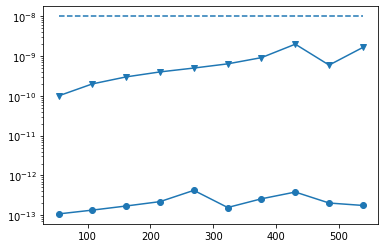

In [109]:
norm = get_norm(ts)
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
color = ['tab:blue','tab:orange','tab:green','tab:purple','k']
for i in range(len(new_error1)):
    ax.plot(norm,new_error[i],color = color[i],marker='o')
    ax.plot(norm,new_error1[i],color = color[i],marker='v')
    ax.plot(norm,tols[i]*np.ones(len(new_error1[i])),'--',color=color[i], label= str(tols[i]))
ax.set_yscale('log')